# <center>Machine Learning Project Code</center>

<a class="anchor" id="top"></a>

## <center>*02 - Holdout Method*</center>

** **



# Table of Contents  <br>


1. [Importing Libraries & Data](#1.-Importing-Libraries-&-Data) <br><br>
    
2. [Train-Test Split](#2.-Train-Test-Split)

   2.1 [Feature Engineering](#2.1-Feature-Engineering) <br>
    
   2.2 [Missing Values](#2.2-Missing-Values) <br>
    
   2.3 [Outliers](#2.3-Outliers) <br><br>
   
3. [Feature Selection](#3.-Feature-Selection) 
    
    3.1 [Filter Based Methods](#3.1-Filter-Based-Methods) <br>

    3.2 [Wrapper Methods](#3.2-Wrapper-Methods) <br>
    
    3.3 [Embedded Methods](#3.3-Embedded-Methods) <br><br>
    
4. [Modeling](#4.-Modeling) <br>

    4.1 [Hyperparameter Tuning](#4.1-Hyperparameter-Tuning) <br><br>

5. [Export](#5.-Export)


** **

In this notebook we will start by spliting train and validation data using a simple Holdout Method. After doing so, more complex methods to fill missing values will be applied, and outliers will be addresses. Feature Selection will also be performed, followed by a Modeling section.

Data Scientist Manager: António Oliveira, **20211595**

Data Scientist Senior: Tomás Ribeiro, **20240526**

Data Scientist Junior: Gonçalo Pacheco, **20240695**

Data Analyst Senior: Gonçalo Custódio, **20211643**

Data Analyst Junior: Ana Caleiro, **20240696**


** ** 

# 1. Importing Libraries & Data
In this section, we set up the foundation for our project by importing the necessary Python libraries and loading the dataset. These libraries provide the tools for data manipulation, visualization, and machine learning modeling throughout the notebook. Additionally, we import the historical claims dataset, which forms the core of our analysis. 

In [1]:
import pandas as pd
import numpy as np

# Preprocessing
import utils2 as p

# Train-Test Split
from sklearn.model_selection import train_test_split

# Scaler
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler
)

# Feature Selection
import feature_selection as fs

# Models
import models as mod
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier 
from lightgbm import LGBMClassifier

from sklearn.impute import SimpleImputer

# Hyperparameter Tuning
import tuning as t

# Metrics
import metrics as m

pd.set_option('display.max_columns', None)
# Suppress Warnings
import warnings
warnings.filterwarnings("ignore")

**Import Data**

In [2]:
# Load training data
df = pd.read_csv('./train_data_EDA.csv', index_col = 'Claim Identifier')

# Load testing data
test = pd.read_csv('./test_data_EDA.csv', index_col = 'Claim Identifier')

# Display the first 3 rows of the training data
df.head(3)

,Age at Injury,Alternative Dispute Resolution,Attorney/Representative,Average Weekly Wage,Birth Year,C-3 Date,Carrier Name,Carrier Type,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Medical Fee Region,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Number of Dependents,Gender Enc,Accident Date Year,Accident Date Month,Accident Date Day,Accident Date Day of Week,Assembly Date Year,Assembly Date Month,Assembly Date Day,Assembly Date Day of Week,C-2 Date Year,C-2 Date Month,C-2 Date Day,C-2 Date Day of Week,Accident to Assembly Time,Assembly to C-2 Time,Accident to C-2 Time,WCIO Codes,Insurance,Zip Code Valid,Industry Sector,Age Group
Claim Identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5393875,31.0,N,N,0.00,1988.0,NaN,NEW HAMPSHIRE INSURANCE CO,1A. PRIVATE,1,ST. LAWRENCE,N,SYRACUSE,NaN,M,NaN,44.0,I,27,10,62,1.0,0,2019.0,12.0,30.0,0.0,2020,1,1,2,2019.0,12.0,31.0,1.0,2.0,1.0,1.0,271062,1,0,Retail and Wholesale,1
5393091,46.0,N,Y,1745.93,1973.0,2020-01-14,ZURICH AMERICAN INSURANCE CO,1A. PRIVATE,3,WYOMING,N,ROCHESTER,2020-02-21,F,4.0,23.0,I,97,49,38,4.0,1,2019.0,8.0,30.0,4.0,2020,1,1,2,2020.0,1.0,1.0,2.0,124.0,0.0,124.0,974938,1,0,Manufacturing and Construction,1
5393889,40.0,N,N,1434.80,1979.0,NaN,INDEMNITY INSURANCE CO OF,1A. PRIVATE,3,ORANGE,N,ALBANY,NaN,M,NaN,56.0,II,79,7,10,6.0,0,2019.0,12.0,6.0,4.0,2020,1,1,2,2020.0,1.0,1.0,2.0,26.0,0.0,26.0,79710,1,0,Business Services,1


# 2. Train-Test Split
The train-test split is a crucial technique used to assess model performance by dividing the dataset into training and testing subsets. This ensures that the model is evaluated on unseen data, helping to prevent overfitting and providing an unbiased performance estimate. 

<a href="#top">Top &#129033;</a>

**Holdout Method**

In [3]:
# Split the DataFrame into features (X) and target variable (y)
X = df.drop('Claim Injury Type', axis=1) 
y = df['Claim Injury Type']  

In [4]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify = y) 

## 2.1 Feature Engineering

<a href="#top">Top &#129033;</a>

### 2.1.1 Encoding

Encoding transforms categorical data into numerical format for use in machine learning models. For this section, several encoders were considered:
- **One Hot Encoding** -  turns a variable that is stored in a column into dummy variables stored over multiple columns and represented as 0s and 1s
- **Frequency Encoding** - replaces the categories by with their proportion in the dataset
- **Count Encoding** - replaces the categories by the number of times they appear in the dataset 
- **Manual Mapping Encoding** - manually attribute values to each category

**Alternative Dispute Resolution**

Knowing that 'N' is by far the most common category, and that 'U' only appears 5 times in DF data and 1 time in the test data, we decided to join 'U' and 'Y' into 'Y/U', and encode the variable as:
- 0 - N
- 1 - Y/U

In [5]:
print(X_train['Alternative Dispute Resolution'].value_counts())
print(' ')
print(test['Alternative Dispute Resolution'].value_counts())

Alternative Dispute Resolution
N    457147
Y      2068
U         5
Name: count, dtype: int64
 
Alternative Dispute Resolution
N    386314
Y      1660
U         1
Name: count, dtype: int64


In [6]:
X_train['Alternative Dispute Resolution Enc'] = X_train['Alternative Dispute Resolution'].replace({'N': 0, 'Y': 1, 'U': 1})
X_val['Alternative Dispute Resolution Enc'] = X_val['Alternative Dispute Resolution'].replace({'N': 0, 'Y': 1, 'U': 1})
test['Alternative Dispute Resolution Enc'] = test['Alternative Dispute Resolution'].replace({'N': 0, 'Y': 1, 'U': 1})

**Attorney/Representative**

As this variable only has 2 categories, they will be encoded as follows:
- N - 0
- Y - 1

In [7]:
print(X_train['Attorney/Representative'].value_counts())
print(' ')
print(test['Attorney/Representative'].value_counts())

Attorney/Representative
N    313769
Y    145451
Name: count, dtype: int64
 
Attorney/Representative
N    306476
Y     81499
Name: count, dtype: int64


In [8]:
X_train['Attorney/Representative Enc'] = X_train['Attorney/Representative'].replace({'N': 0, 'Y': 1})
X_val['Attorney/Representative Enc'] = X_val['Attorney/Representative'].replace({'N': 0, 'Y': 1})
test['Attorney/Representative Enc'] = test['Attorney/Representative'].replace({'N': 0, 'Y': 1})

**Carrier Name**

As Carrier name has a considerable amount of unique values, it will be encoded using Count Encoder.

We will start by analysing the common Carriers between train and test sets

In [9]:
train_carriers = set(X_train['Carrier Name'].unique())
test_carriers = set(test['Carrier Name'].unique())

common_categories = train_carriers.intersection(test_carriers)

Then map the common categories to an index

In [10]:
common_category_map = {category: idx + 1 for idx, 
                       category in enumerate(common_categories)}

Fill the non-common categories with 0

In [11]:
X_train['Carrier Name'] = X_train['Carrier Name'].map(common_category_map).fillna(0).astype(int)
X_val['Carrier Name'] = X_val['Carrier Name'].map(common_category_map).fillna(0).astype(int)
test['Carrier Name'] = test['Carrier Name'].map(common_category_map).fillna(0).astype(int)

Encode de common categores using *Count Encoding*

In [12]:
X_train, X_val, test = p.encode(X_train, X_val, test, 'Carrier Name', 'count')

**Carrier Type**

After grouping the *5.* categories we decided to encode them in 2 distinct ways, and choose the best option in feature selection.

Starting with *Count Encoding*

In [13]:
X_train, X_val, test = p.encode(X_train, X_val, test, 'Carrier Type', 'count')

And *One-Hot-Encoding*

In [14]:
X_train, X_val, test = p.encode(X_train, X_val, test, 'Carrier Type', 'OHE')

**County of Injury**

As County of Injury has a considerable amount of unique values, it will be encoded using Count Encoder.

In [15]:
X_train, X_val, test = p.encode(X_train, X_val, test, 'County of Injury', 'count')

**COVID-19 Indicator**

As this variable only has 2 categories, they will be encoded as follows:
- N - 0
- Y - 1

In [16]:
print(X_train['COVID-19 Indicator'].value_counts())
print(' ')
print(test['COVID-19 Indicator'].value_counts())

COVID-19 Indicator
N    437124
Y     22096
Name: count, dtype: int64
 
COVID-19 Indicator
N    385434
Y      2541
Name: count, dtype: int64


In [17]:
X_train['COVID-19 Indicator Enc'] = X_train['COVID-19 Indicator'].replace({'N': 0, 'Y': 1})
X_val['COVID-19 Indicator Enc'] = X_val['COVID-19 Indicator'].replace({'N': 0, 'Y': 1})
test['COVID-19 Indicator Enc'] = test['COVID-19 Indicator'].replace({'N': 0, 'Y': 1})

**District Name**

As this variable has 8 unique values, Count Encoder will be used.

In [18]:
print(X_train['District Name'].value_counts())
print(' ')
print(test['District Name'].value_counts())

District Name
NYC           216769
ALBANY         68742
HAUPPAUGE      48555
BUFFALO        36490
SYRACUSE       35811
ROCHESTER      32225
BINGHAMTON     17439
STATEWIDE       3189
Name: count, dtype: int64
 
District Name
NYC           187972
ALBANY         56500
HAUPPAUGE      36656
BUFFALO        31481
SYRACUSE       29537
ROCHESTER      28073
BINGHAMTON     15382
STATEWIDE       2374
Name: count, dtype: int64


In [19]:
X_train, X_val, test = p.encode(X_train, X_val, test, 'District Name', 'count')

**Gender**

Since after grouping we only have 3 categories, we will also use *One-Hot-Encoding* and decide which is better in feature selection.

In [20]:
X_train, X_val, test = p.encode(X_train, X_val, test, 'Gender', 'OHE')

**Medical Fee Region**

Even though this variable only contains 5 unique values, it is not clear whether there is an order between them or not. Therefore we will use *Count Encoding*

In [21]:
print(df['Medical Fee Region'].value_counts())
print(' ')
print(test['Medical Fee Region'].value_counts())

Medical Fee Region
IV     265981
I      135885
II      85033
III     53654
UK      33472
Name: count, dtype: int64
 
Medical Fee Region
IV     182276
I       91300
II      58743
III     34679
UK      20977
Name: count, dtype: int64


In [22]:
X_train, X_val, test = p.encode(X_train, X_val, test, 'Medical Fee Region', 'count')

**Industry Sector**

Since it contains too many categories to use OHE, we will use *Count Encoding*

In [23]:
X_train, X_val, test = p.encode(X_train, X_val, test, 'Industry Sector', 'count')

Remove Encoded Variables

In [24]:
drop = ['Alternative Dispute Resolution', 'Attorney/Representative', 'Carrier Type', 'County of Injury',
        'COVID-19 Indicator', 'District Name', 'Gender', 'Carrier Name',
        'Medical Fee Region', 'Industry Sector']

In [25]:
X_train.drop(columns = drop, axis = 1, inplace = True)
X_val.drop(columns = drop, axis = 1, inplace = True)
test.drop(columns = drop, axis = 1, inplace = True)

# 2.2 Missing Values

<a href="#top">Top &#129033;</a>

In [26]:
X_train.isna().sum()

Age at Injury                                   0
Average Weekly Wage                         22968
Birth Year                                  23204
C-3 Date                                   309591
First Hearing Date                         338649
IME-4 Count                                353010
Industry Code                                7959
WCIO Cause of Injury Code                       0
WCIO Nature of Injury Code                      0
WCIO Part Of Body Code                          0
Number of Dependents                            0
Gender Enc                                      0
Accident Date Year                           2959
Accident Date Month                          2959
Accident Date Day                            2959
Accident Date Day of Week                    2959
Assembly Date Year                              0
Assembly Date Month                             0
Assembly Date Day                               0
Assembly Date Day of Week                       0


### 2.2.1 Dealing with Missing Values

In this subsection we will use the existence of missing values to create new features

**C-3 Date**

Create a Binary variable:
- 0 if C-3 date is missing
- 1 if C-3 date exists

In [27]:
X_train['C-3 Date Binary'] = X_train['C-3 Date'].notna().astype(int)
X_val['C-3 Date Binary'] = X_val['C-3 Date'].notna().astype(int)
test['C-3 Date Binary'] = test['C-3 Date'].notna().astype(int)

**First Hearing Date**

Create a Binary variable:
- 0 if First Hearing Date is missing
- 1 if First Hearing Date exists

In [28]:
X_train['First Hearing Date Binary'] = X_train['First Hearing Date'].notna().astype(int)
X_val['First Hearing Date Binary'] = X_val['First Hearing Date'].notna().astype(int)
test['First Hearing Date Binary'] = test['First Hearing Date'].notna().astype(int)

Remove transformed features.

In [29]:
drop = ['C-3 Date', 'First Hearing Date']

In [30]:
X_train.drop(columns = drop, axis = 1, inplace = True)
X_val.drop(columns = drop, axis = 1, inplace = True)
test.drop(columns = drop, axis = 1, inplace = True)

### 2.2.2 Filling Missing Values

In this subsection we will deal with missing values by filling them with constants, statistical methods and using predictive models.

**IME-4 Count**

Since IME-4 Count represents the number of IME-4 forms received per claim, we considered that a missing value represented 0 received forms, hence we will fill them with 0.

In [31]:
X_train['IME-4 Count'] = X_train['IME-4 Count'].fillna(0)
X_val['IME-4 Count'] = X_val['IME-4 Count'].fillna(0)
test['IME-4 Count'] = test['IME-4 Count'].fillna(0)

**Industry Code**

Assuming that a missing value in Industry Code represents an unknown code, it will be filled with 0.

In [32]:
X_train['Industry Code'] = X_train['Industry Code'].fillna(0)
X_val['Industry Code'] = X_val['Industry Code'].fillna(0)
test['Industry Code'] = test['Industry Code'].fillna(0)

**Accident Date** & **C-2 Date**

Fill Year, Month and Day with median. Then recompute full date and from there fill missing values in Day of Week

In [33]:
p.fill_dates(X_train, [X_val, test], 'Accident Date')
p.fill_dates(X_train, [X_val, test], 'C-2 Date')

Identify missing values and recompute Accident Date and C-2 Date to fill Day of the week

In [34]:
p.fill_dow([X_train, X_val, test], 'Accident Date')
p.fill_dow([X_train, X_val, test], 'C-2 Date')

**Time Between**

Fill missing values with the recomputed times using the medians computed above.

In [35]:
X_train = p.fill_missing_times(X_train, ['Accident to Assembly Time', 
                             'Assembly to C-2 Time',
                             'Accident to C-2 Time'])

X_val = p.fill_missing_times(X_val, ['Accident to Assembly Time', 
                             'Assembly to C-2 Time',
                             'Accident to C-2 Time'])

test = p.fill_missing_times(test, ['Accident to Assembly Time', 
                             'Assembly to C-2 Time',
                             'Accident to C-2 Time'])

**Birth Year**

To fill the missing values, we will start by creating a mask, which filters for observations where `Age at Injury` and `Accident Date Year` are not missing, and when `Birth Year` is either missing or zero. Since we are going to use `Age at Injury` and `Accident Date Year` to compute `Birth Year`, ensuring those two variables are no missing is crucial. Then, we also decided to recompute the `Birth Year` when it is 0, since it is impossible to have 0 as a `Birth Year`.

In [36]:
p.fill_birth_year([X_train, X_val, test])

Before filling the missing values in `Average Weekly Wage` we must scale all numeric and Count-Encoded Features, as doing so after filling these missing values may lead to inconsistencies.

Having evaluated models with scaling before and after the imputation in this variables, the difference in performance was not signficant, therefore we will proceed with the scaling first.

### 2.2.3 Scaling

<a href="#top">Top &#129033;</a>

**Variable type split**

In [37]:
num = ['Age at Injury', 'Average Weekly Wage', 'Birth Year',
       'IME-4 Count', 'Number of Dependents', 'Accident Date Year',
       'Accident Date Month', 'Accident Date Day', 
       'Assembly Date Year', 'Assembly Date Month', 
       'Assembly Date Day', 'C-2 Date Year', 'C-2 Date Month',
       'C-2 Date Day', 'Accident to Assembly Time',
       'Assembly to C-2 Time', 'Accident to C-2 Time']
      # 'Wage to Age Ratio', 'Average Weekly Wage Sqrt',
      # 'IME-4 Count Log', 'IME-4 Count Double Log']

 
categ = [var for var in X_train.columns if var not in num]

categ_count_encoding = ['Carrier Name Enc', 'Carrier Type Enc',
                        'County of Injury Enc', 'District Name Enc',
                        'Medical Fee Region Enc', 'Industry Sector Enc']


categ_label_bin = [var for var in X_train.columns if var
                   in categ and var not in categ_count_encoding]


**Scaling**

In [38]:
num_count_enc = num + categ_count_encoding

In [39]:
robust = RobustScaler()

In [40]:
# Scaling the numerical features in the training set using RobustScaler
X_train_num_count_enc_RS = robust.fit_transform(X_train[num_count_enc])
X_train_num_count_enc_RS = pd.DataFrame(X_train_num_count_enc_RS, columns=num_count_enc, index=X_train.index)

# Scaling the numerical features in the validation set using the fitted RobustScaler
X_val_num_count_enc_RS = robust.transform(X_val[num_count_enc])
X_val_num_count_enc_RS = pd.DataFrame(X_val_num_count_enc_RS, columns=num_count_enc, index=X_val.index)

# Scaling the numerical features in the test set using the same fitted RobustScaler
test_num_count_enc_RS = robust.transform(test[num_count_enc])
test_num_count_enc_RS = pd.DataFrame(test_num_count_enc_RS, columns=num_count_enc, index=test.index)

Joining the scaled features back with the Categorical features encoded with labels or binary encoding

In [41]:
X_train_RS = pd.concat([X_train_num_count_enc_RS, 
                        X_train[categ_label_bin]], axis=1)
X_val_RS = pd.concat([X_val_num_count_enc_RS, 
                      X_val[categ_label_bin]], axis=1)
test_RS = pd.concat([test_num_count_enc_RS, 
                     test[categ_label_bin]], axis=1)

Having scaled our features, we will proceed with the imputation of missing values.

**Average Weekly Wage**

In [42]:
p.ball_tree_impute([X_train_RS, X_val_RS, test_RS], 
                   'Average Weekly Wage')

Having treated all missing values, we will create one last feature

**Wage to Age Ratio**

In [43]:
# X_train_RS['Wage to Age Ratio'] = np.where(
#     (X_train_RS['Age at Injury'] != 0) & (X_train_RS['Average Weekly Wage'] != 0),
#     X_train_RS['Average Weekly Wage'] / X_train_RS['Age at Injury'],
#     0)

# X_val_RS['Wage to Age Ratio'] = np.where(
#     (X_val_RS['Age at Injury'] != 0) & (X_val_RS['Average Weekly Wage'] != 0),
#     X_val_RS['Average Weekly Wage'] / X_val_RS['Age at Injury'],
#     0)

# test_RS['Wage to Age Ratio'] = np.where(
#     (test_RS['Age at Injury'] != 0) & (test_RS['Average Weekly Wage'] != 0),
#     test_RS['Average Weekly Wage'] / test_RS['Age at Injury'],
#     0)


# 2.3 Outliers

<a href="#top">Top &#129033;</a>

### Outlier Detection

To detect outliers we will use a function that plots boxplots and identifies outliers based on the Interquartile Range method. This function will also add to a list all columns with a higher percentage of outliers than a previously set threshold.

Column: Age at Injury - Number of Outliers: 165
Column: Age at Injury - % of Outliers: 0.04% 



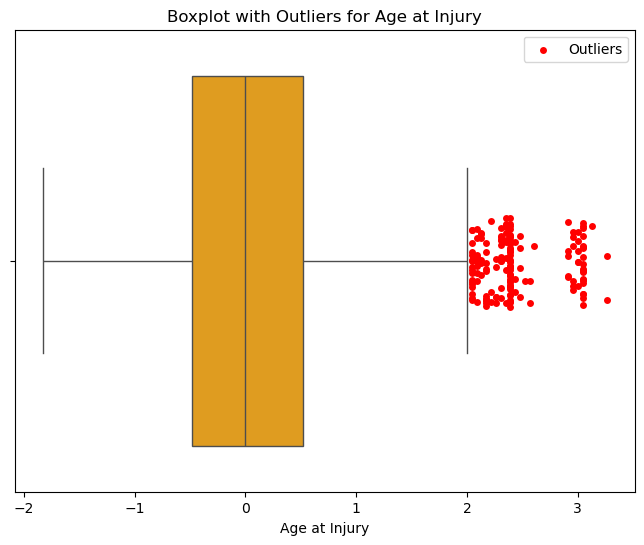

Column: Average Weekly Wage - Number of Outliers: 18786
Column: Average Weekly Wage - % of Outliers: 4.09% 



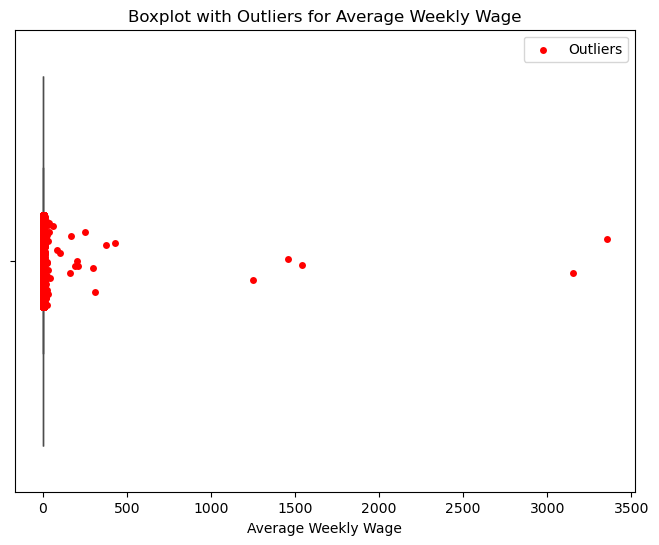

Column: Birth Year - Number of Outliers: 280
Column: Birth Year - % of Outliers: 0.06% 



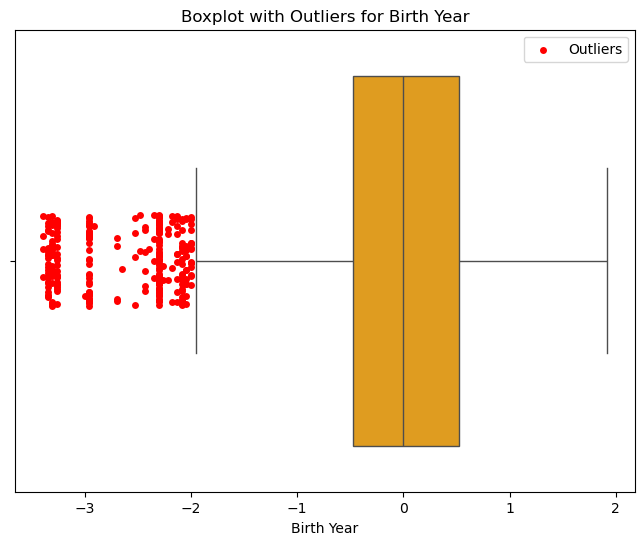

Column: IME-4 Count - Number of Outliers: 106210
Column: IME-4 Count - % of Outliers: 23.13% 



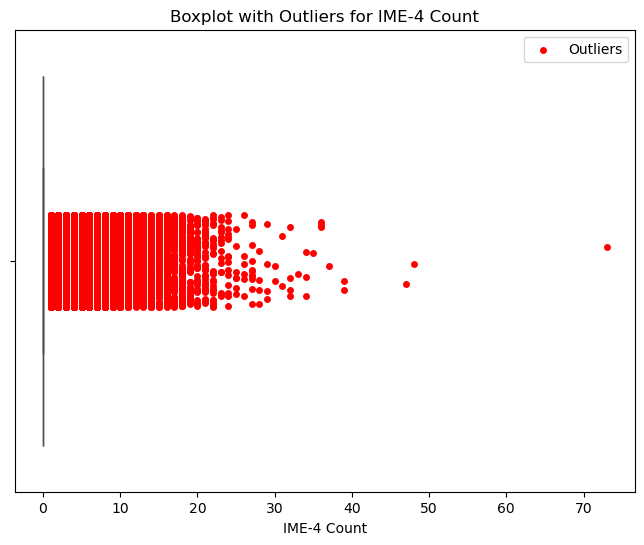

Column: Number of Dependents - Number of Outliers: 0
Column: Number of Dependents - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


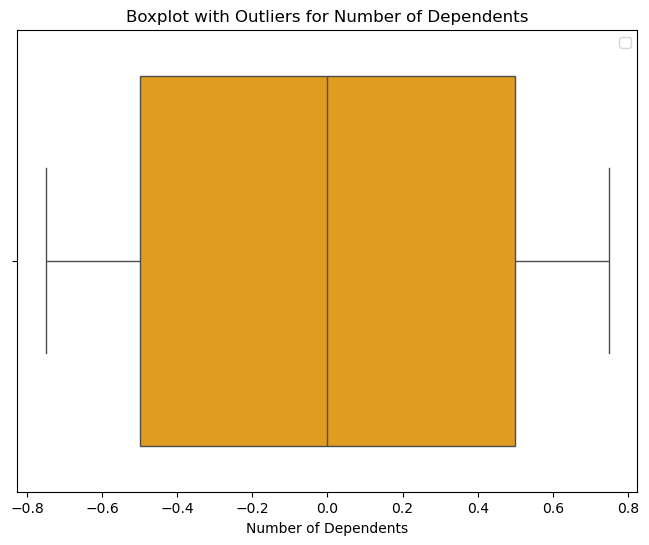

Column: Accident Date Year - Number of Outliers: 3898
Column: Accident Date Year - % of Outliers: 0.85% 



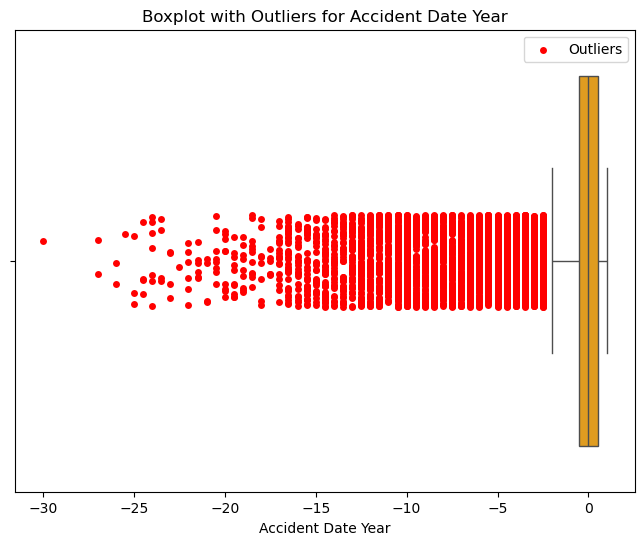

Column: Accident Date Month - Number of Outliers: 0
Column: Accident Date Month - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


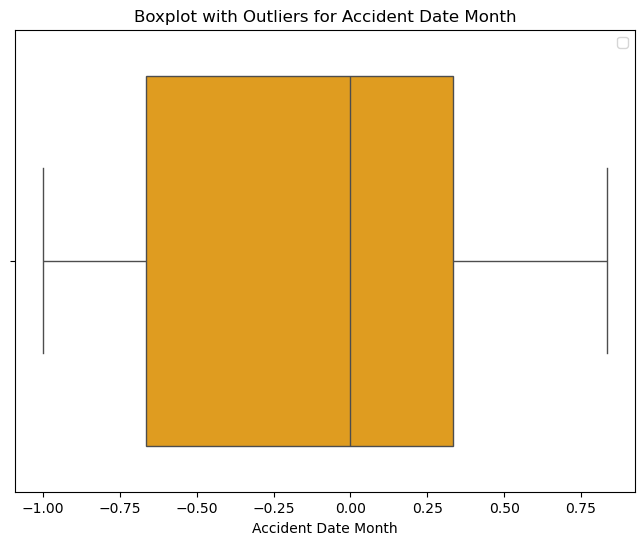

Column: Accident Date Day - Number of Outliers: 0
Column: Accident Date Day - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


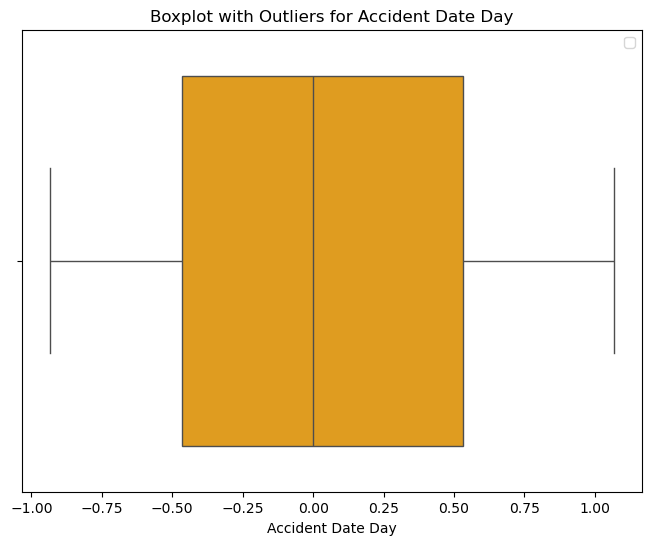

Column: Assembly Date Year - Number of Outliers: 0
Column: Assembly Date Year - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


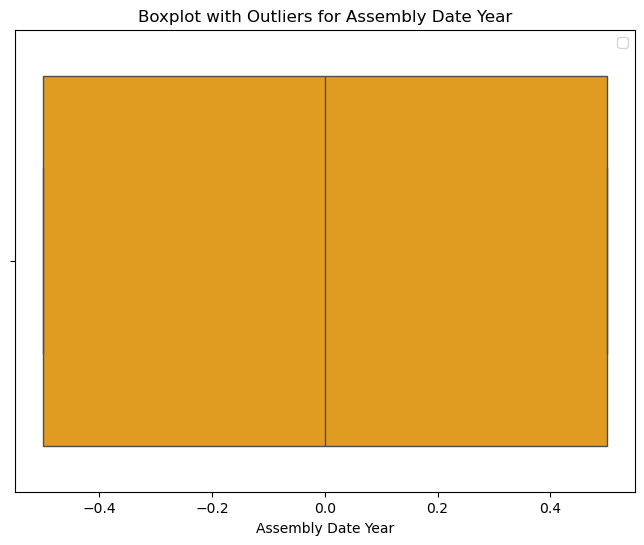

Column: Assembly Date Month - Number of Outliers: 0
Column: Assembly Date Month - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


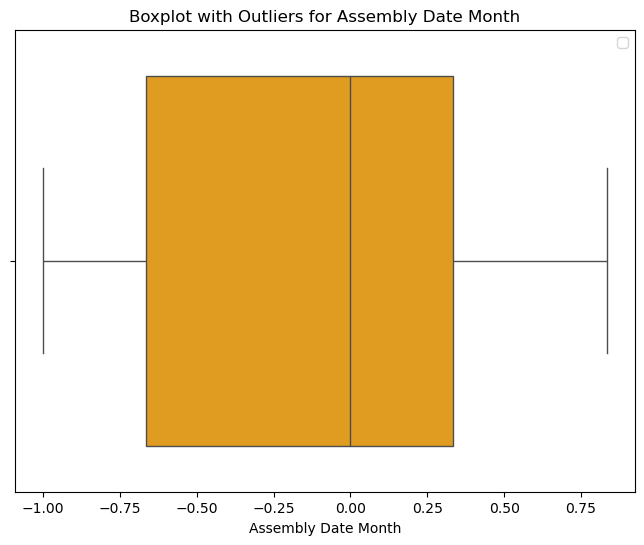

Column: Assembly Date Day - Number of Outliers: 0
Column: Assembly Date Day - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


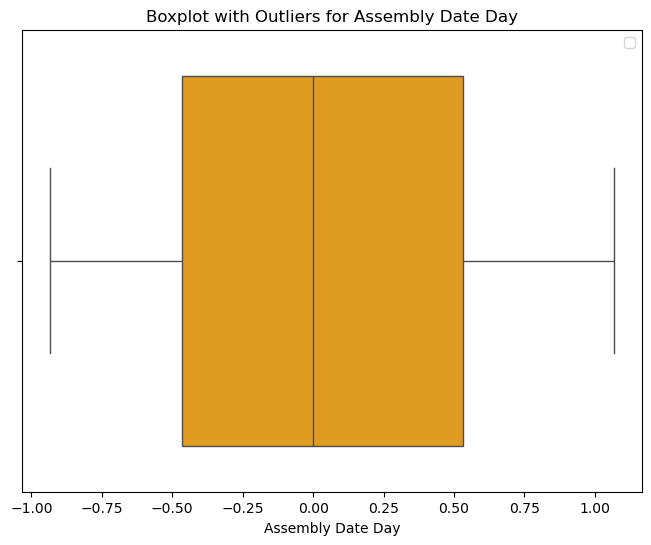

Column: C-2 Date Year - Number of Outliers: 970
Column: C-2 Date Year - % of Outliers: 0.21% 



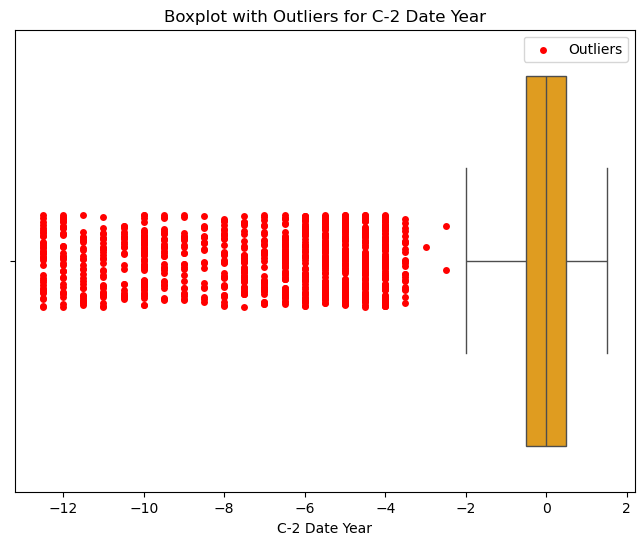

Column: C-2 Date Month - Number of Outliers: 0
Column: C-2 Date Month - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


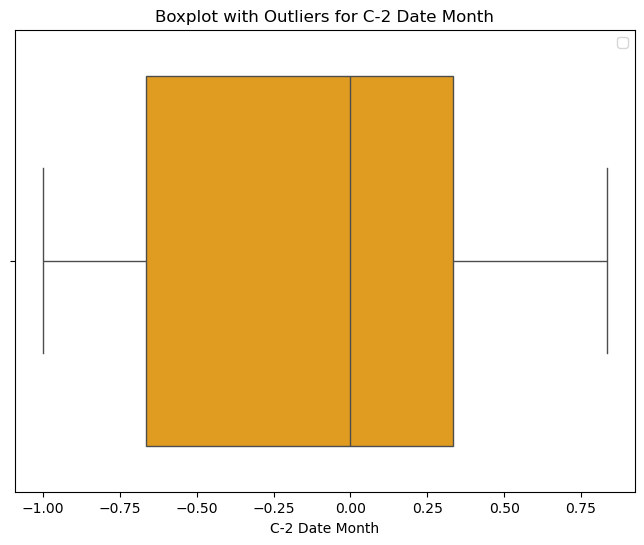

Column: C-2 Date Day - Number of Outliers: 0
Column: C-2 Date Day - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


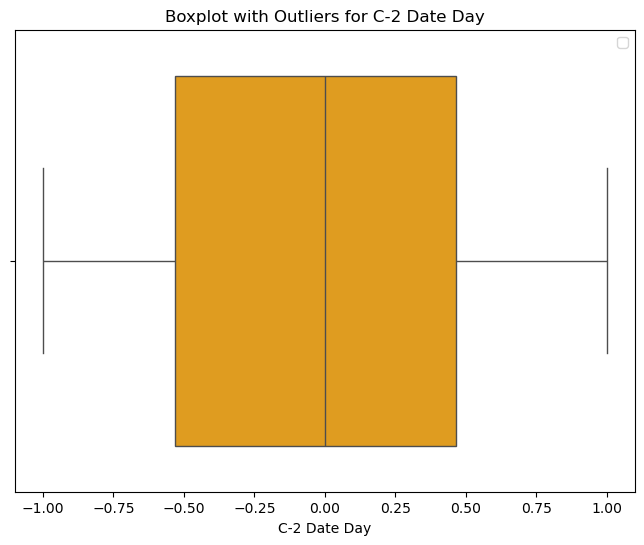

Column: Accident to Assembly Time - Number of Outliers: 61352
Column: Accident to Assembly Time - % of Outliers: 13.36% 



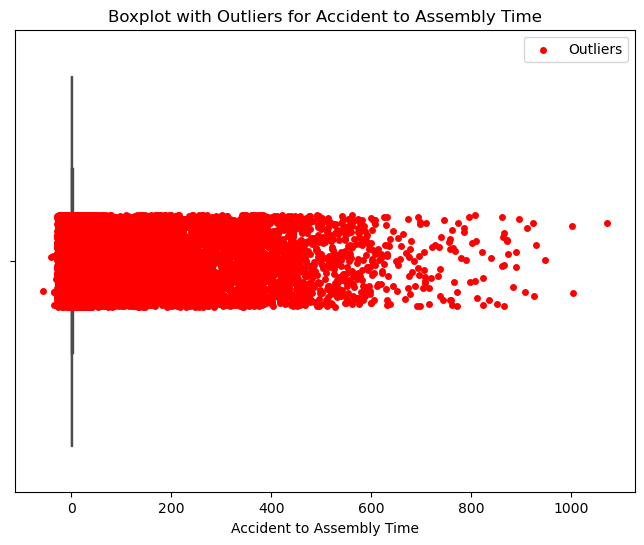

Column: Assembly to C-2 Time - Number of Outliers: 132798
Column: Assembly to C-2 Time - % of Outliers: 28.92% 



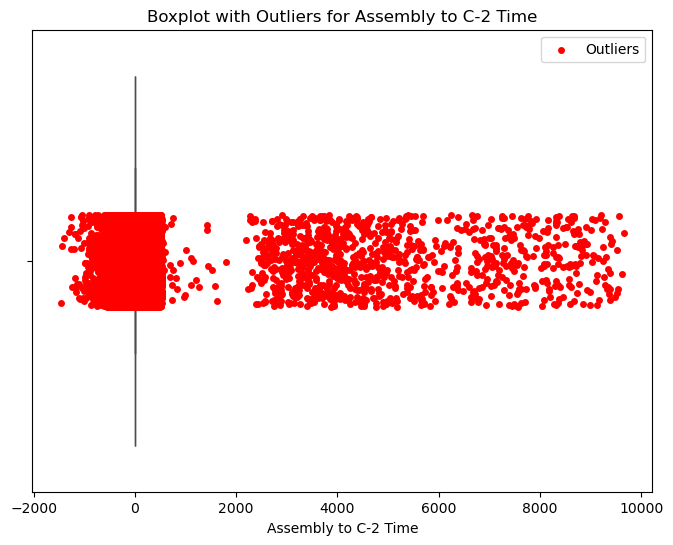

Column: Accident to C-2 Time - Number of Outliers: 72375
Column: Accident to C-2 Time - % of Outliers: 15.76% 



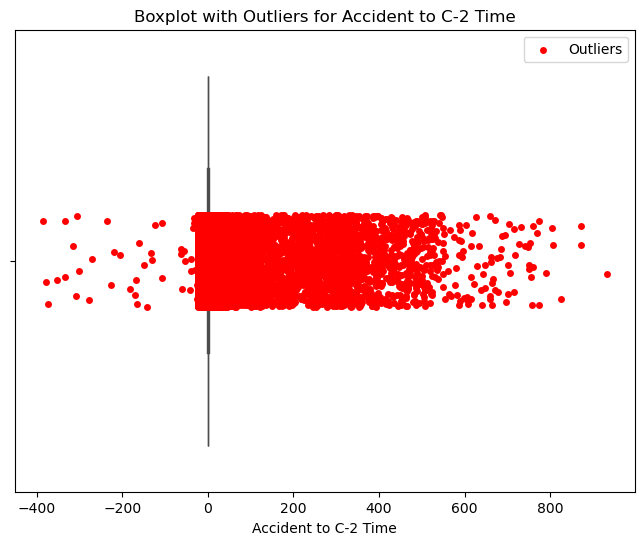

Column: Carrier Name Enc - Number of Outliers: 88880
Column: Carrier Name Enc - % of Outliers: 19.35% 



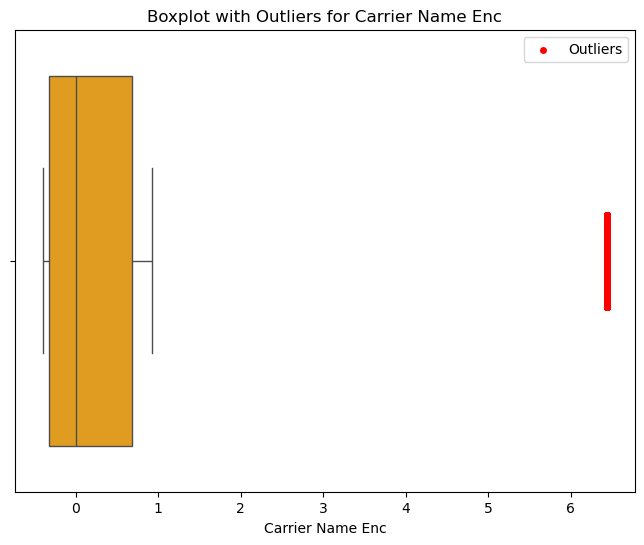

Column: Carrier Type Enc - Number of Outliers: 0
Column: Carrier Type Enc - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


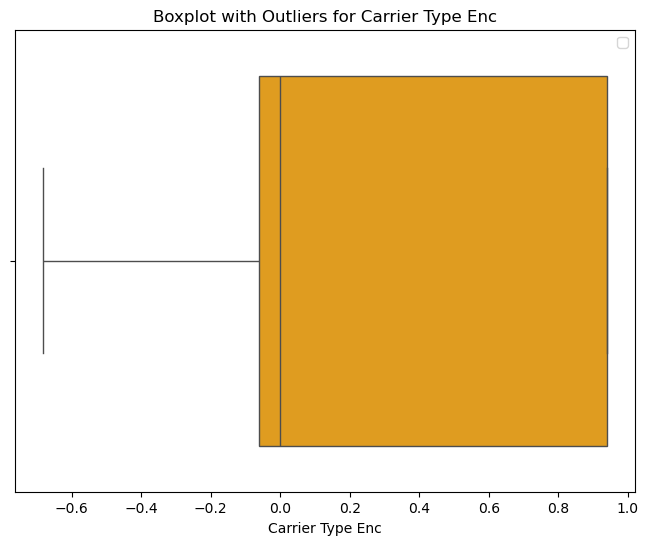

Column: County of Injury Enc - Number of Outliers: 0
Column: County of Injury Enc - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


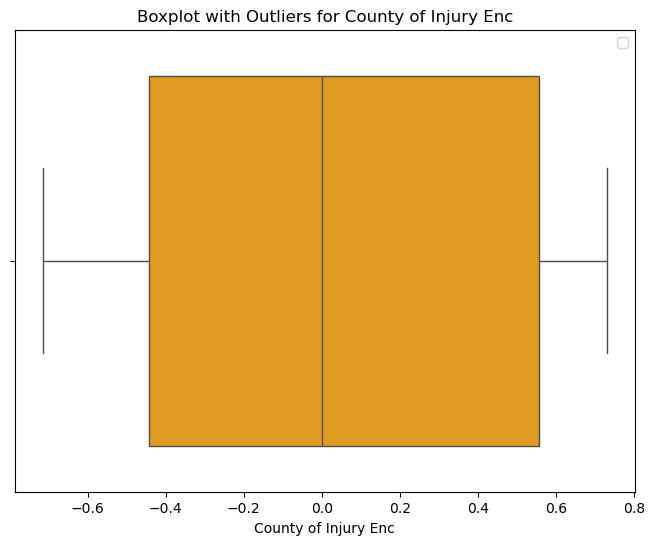

Column: District Name Enc - Number of Outliers: 0
Column: District Name Enc - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


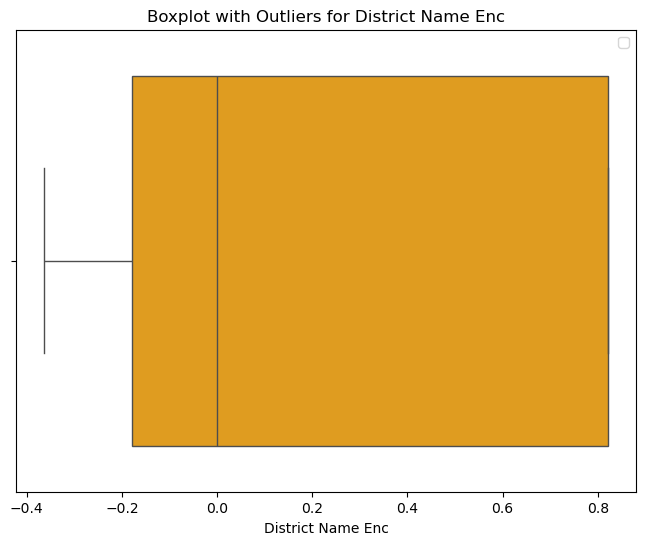

Column: Medical Fee Region Enc - Number of Outliers: 0
Column: Medical Fee Region Enc - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


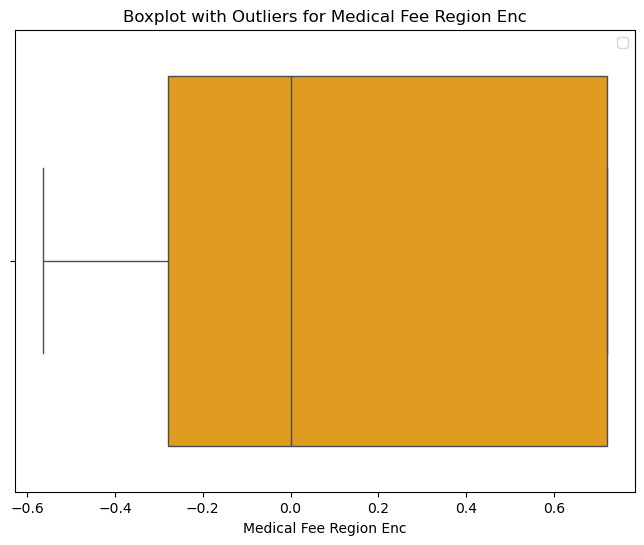

Column: Industry Sector Enc - Number of Outliers: 0
Column: Industry Sector Enc - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


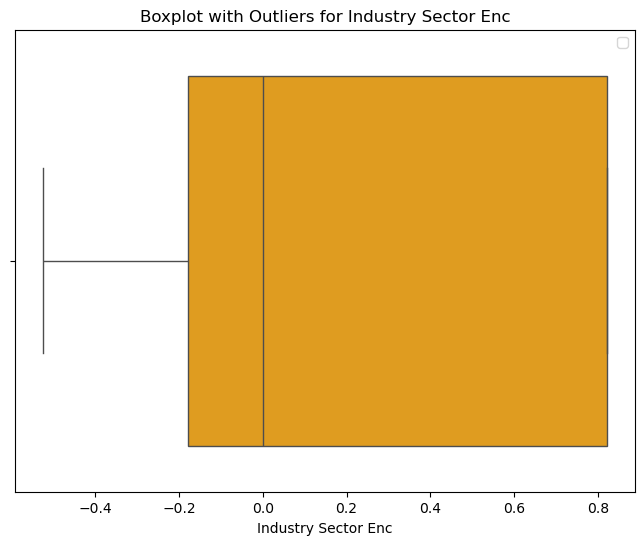

Column: Industry Code - Number of Outliers: 83608
Column: Industry Code - % of Outliers: 18.21% 



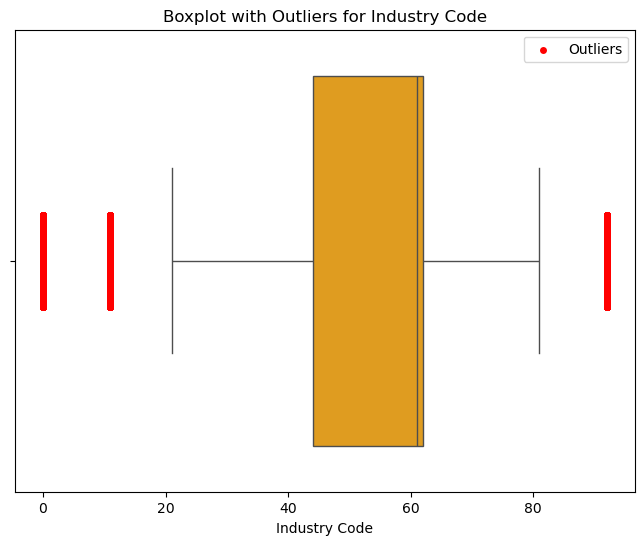

Column: WCIO Cause of Injury Code - Number of Outliers: 0
Column: WCIO Cause of Injury Code - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


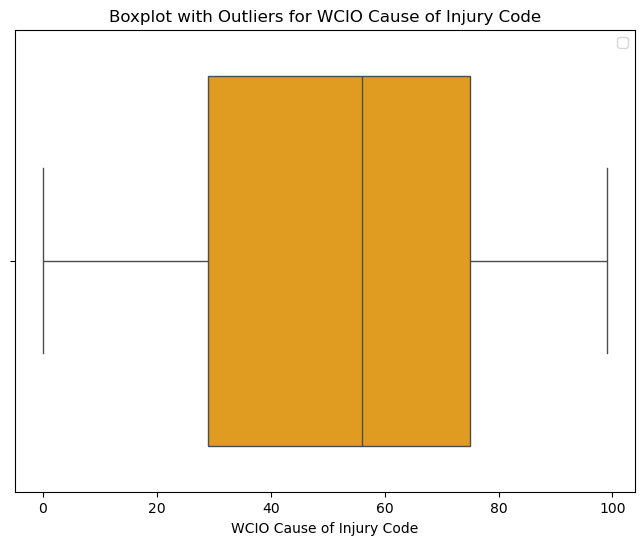

Column: WCIO Nature of Injury Code - Number of Outliers: 0
Column: WCIO Nature of Injury Code - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


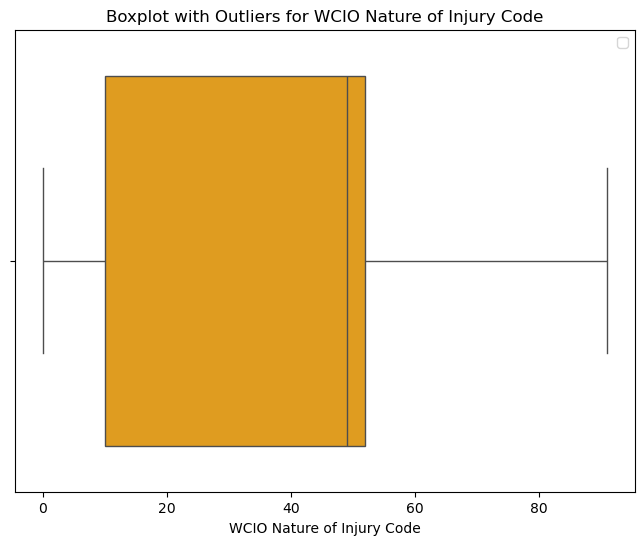

Column: WCIO Part Of Body Code - Number of Outliers: 41536
Column: WCIO Part Of Body Code - % of Outliers: 9.04% 



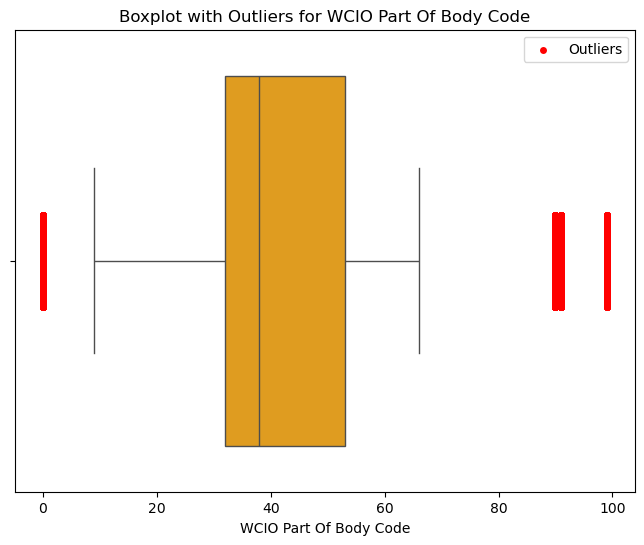

Column: Gender Enc - Number of Outliers: 0
Column: Gender Enc - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


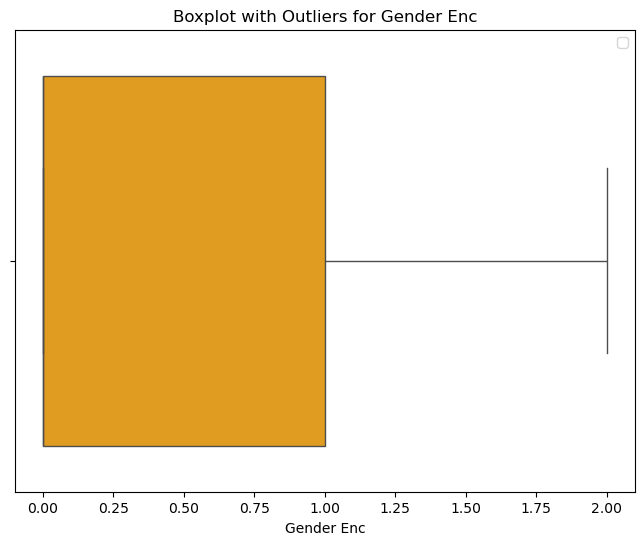

Column: Accident Date Day of Week - Number of Outliers: 0
Column: Accident Date Day of Week - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


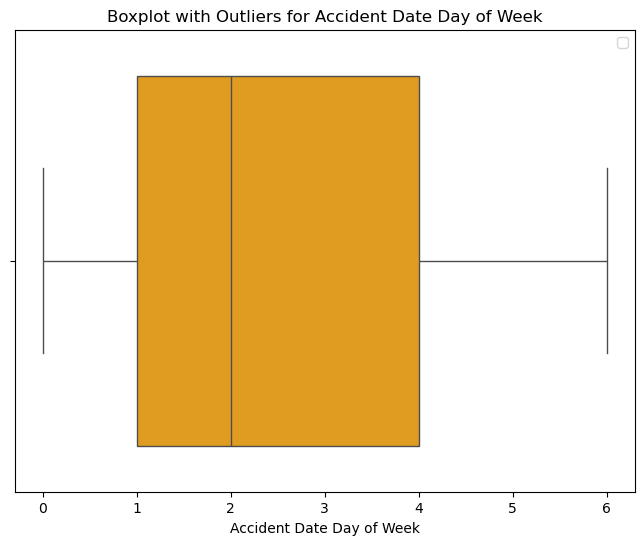

Column: Assembly Date Day of Week - Number of Outliers: 0
Column: Assembly Date Day of Week - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


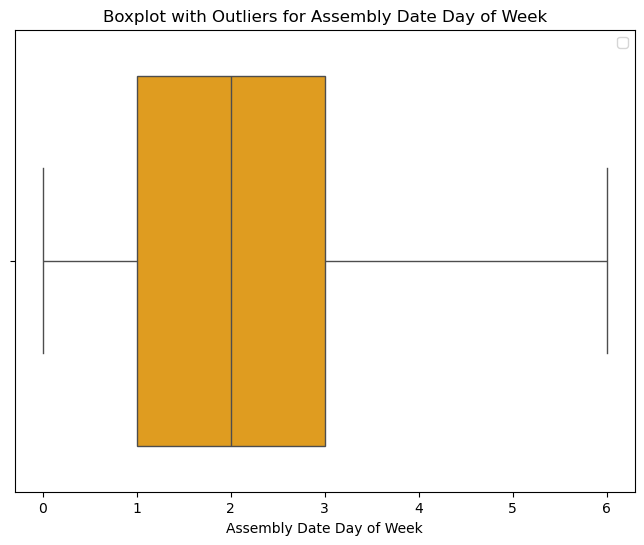

Column: C-2 Date Day of Week - Number of Outliers: 0
Column: C-2 Date Day of Week - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


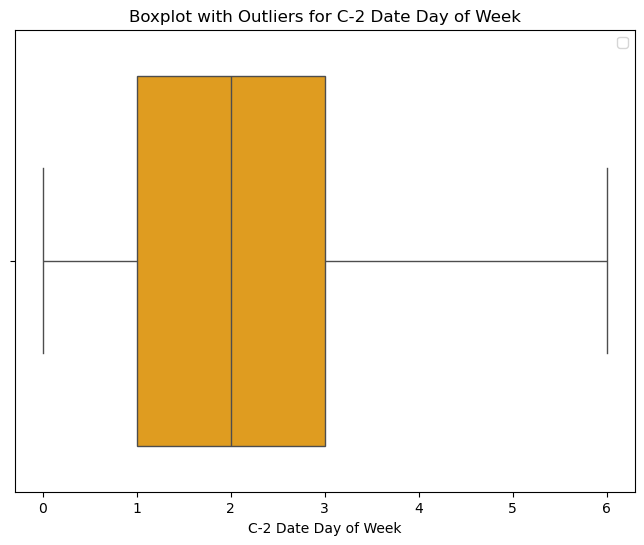

Column: WCIO Codes - Number of Outliers: 0
Column: WCIO Codes - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


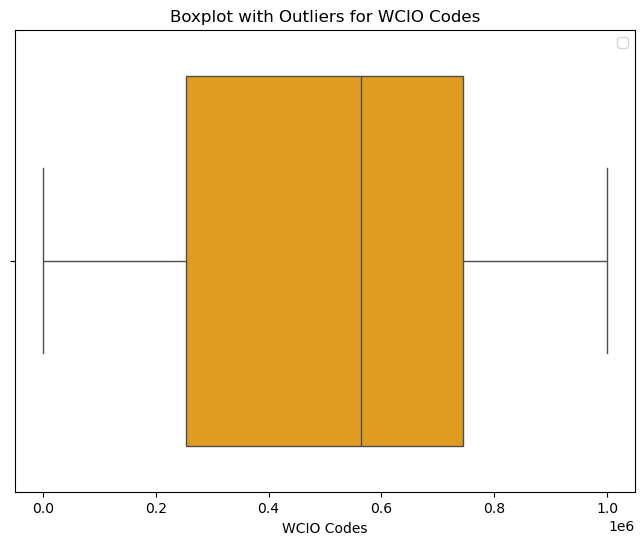

Column: Insurance - Number of Outliers: 0
Column: Insurance - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


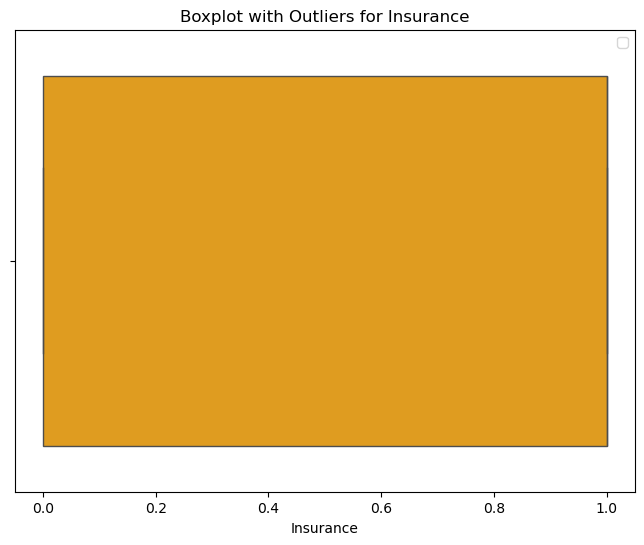

Column: Zip Code Valid - Number of Outliers: 35126
Column: Zip Code Valid - % of Outliers: 7.65% 



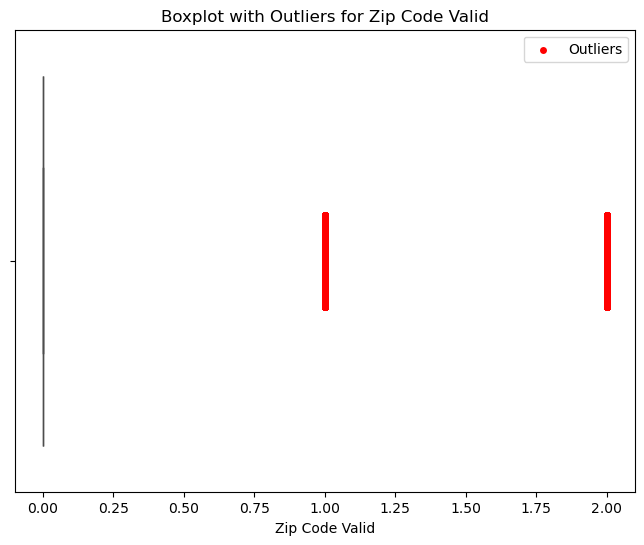

Column: Age Group - Number of Outliers: 26124
Column: Age Group - % of Outliers: 5.69% 



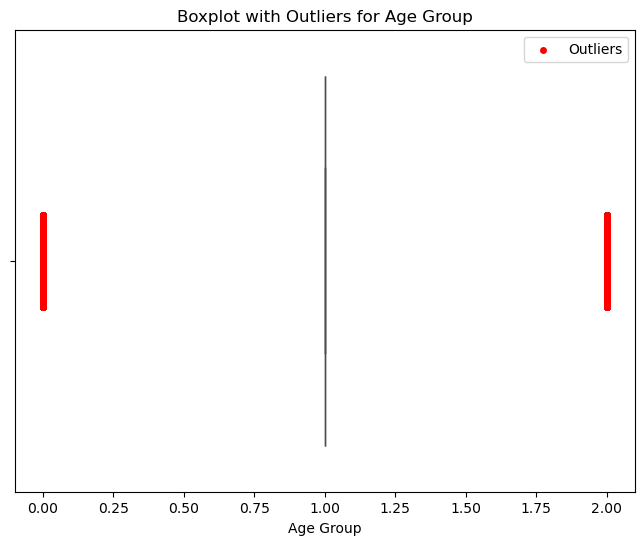

Column: Alternative Dispute Resolution Enc - Number of Outliers: 2073
Column: Alternative Dispute Resolution Enc - % of Outliers: 0.45% 



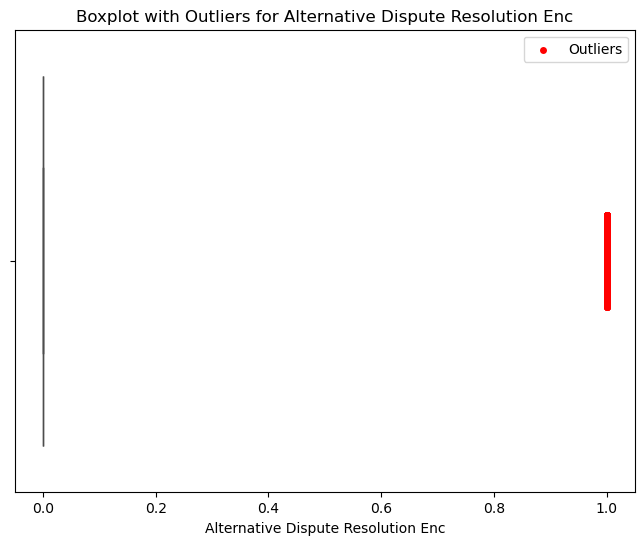

Column: Attorney/Representative Enc - Number of Outliers: 0
Column: Attorney/Representative Enc - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


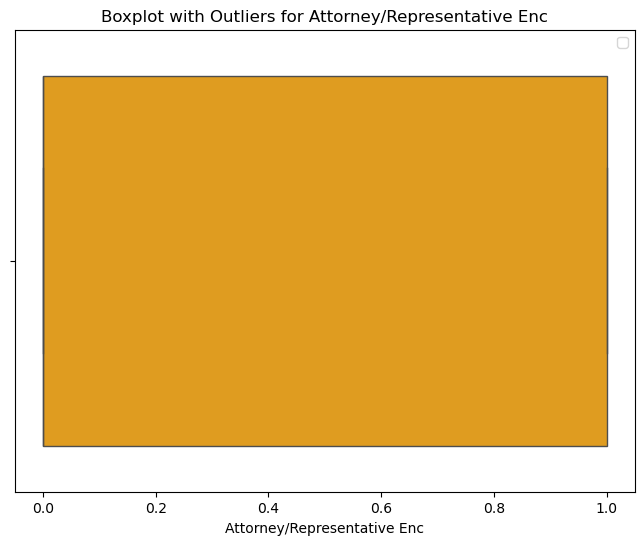

Column: Carrier Type_2A. SIF - Number of Outliers: 88880
Column: Carrier Type_2A. SIF - % of Outliers: 19.35% 



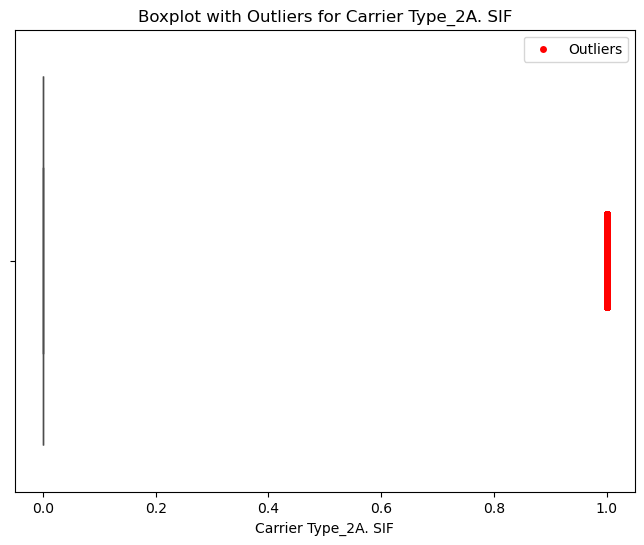

Column: Carrier Type_3A. SELF PUBLIC - Number of Outliers: 97437
Column: Carrier Type_3A. SELF PUBLIC - % of Outliers: 21.22% 



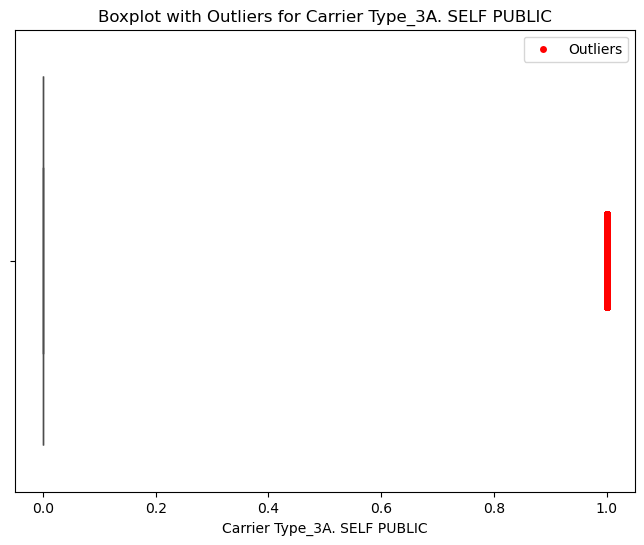

Column: Carrier Type_4A. SELF PRIVATE - Number of Outliers: 42176
Column: Carrier Type_4A. SELF PRIVATE - % of Outliers: 9.18% 



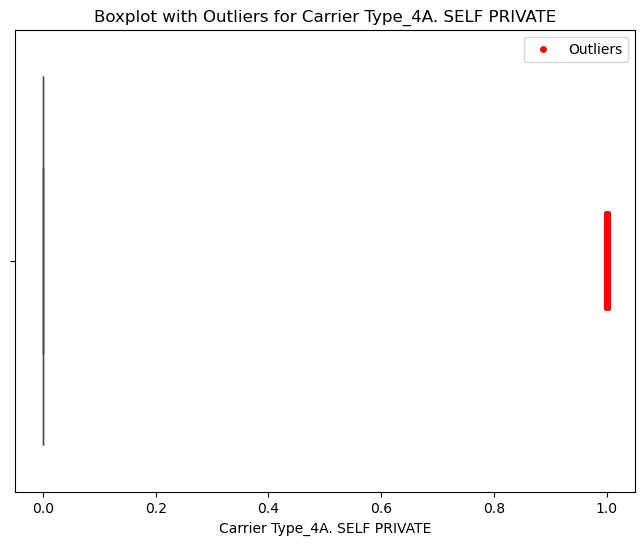

Column: Carrier Type_5. SPECIAL FUND OR UNKNOWN - Number of Outliers: 2243
Column: Carrier Type_5. SPECIAL FUND OR UNKNOWN - % of Outliers: 0.49% 



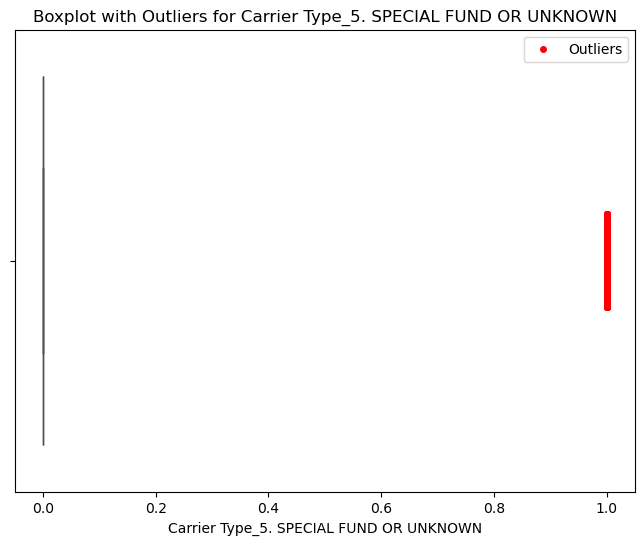

Column: COVID-19 Indicator Enc - Number of Outliers: 22096
Column: COVID-19 Indicator Enc - % of Outliers: 4.81% 



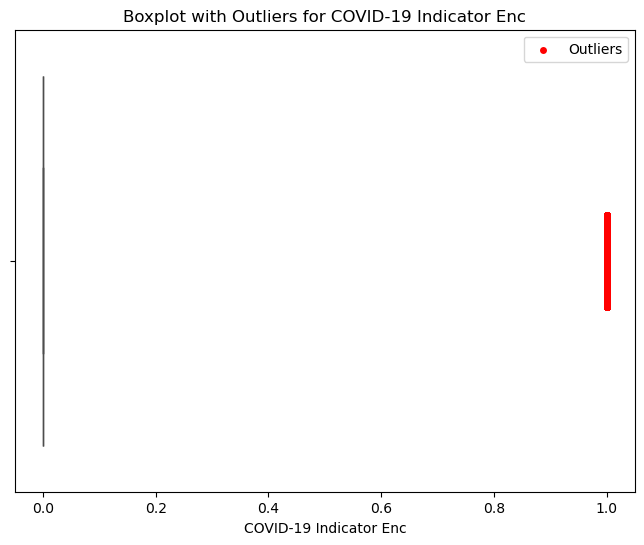

Column: Gender_M - Number of Outliers: 0
Column: Gender_M - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


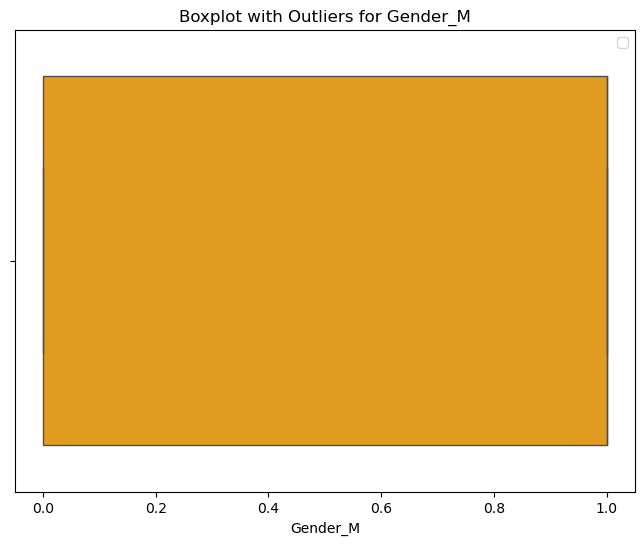

Column: Gender_U/X - Number of Outliers: 3775
Column: Gender_U/X - % of Outliers: 0.82% 



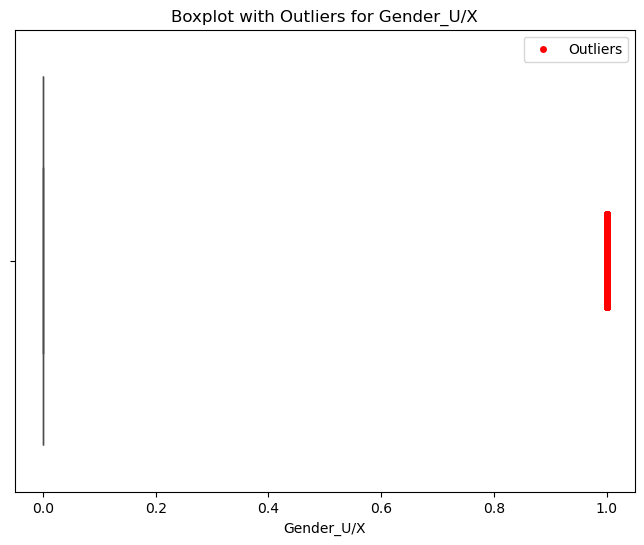

Column: C-3 Date Binary - Number of Outliers: 0
Column: C-3 Date Binary - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


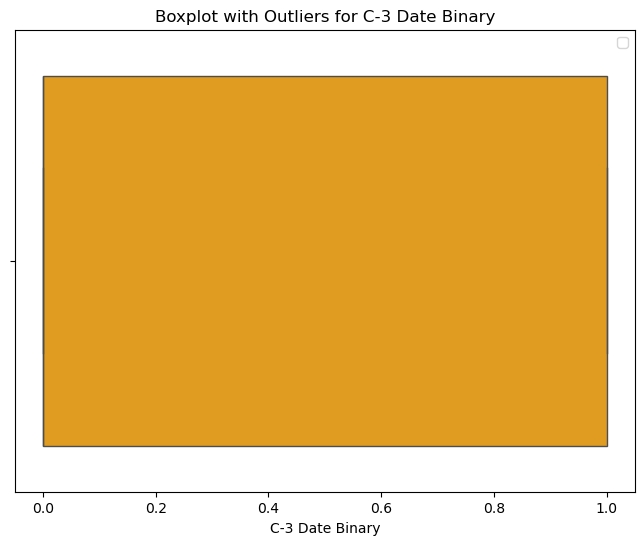

Column: First Hearing Date Binary - Number of Outliers: 0
Column: First Hearing Date Binary - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


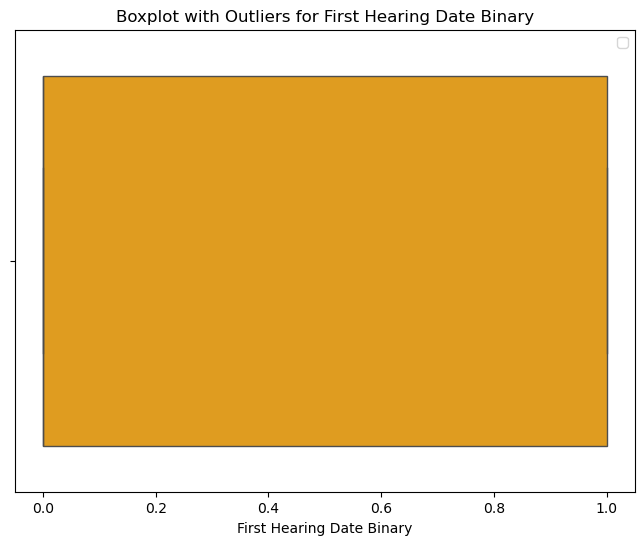

Columns with more than 0.001% Outliers:
['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'IME-4 Count', 'Accident Date Year', 'C-2 Date Year', 'Accident to Assembly Time', 'Assembly to C-2 Time', 'Accident to C-2 Time', 'Carrier Name Enc', 'Industry Code', 'WCIO Part Of Body Code', 'Zip Code Valid', 'Age Group', 'Alternative Dispute Resolution Enc', 'Carrier Type_2A. SIF', 'Carrier Type_3A. SELF PUBLIC', 'Carrier Type_4A. SELF PRIVATE', 'Carrier Type_5. SPECIAL FUND OR UNKNOWN', 'COVID-19 Indicator Enc', 'Gender_U/X']


{'Age at Injury': {'lower_bound': -1.9782608695652173,
  'upper_bound': 2.0217391304347827},
 'Average Weekly Wage': {'lower_bound': -1.4770910901890104,
  'upper_bound': 2.4618184836483508},
 'Birth Year': {'lower_bound': -1.9782608695652173,
  'upper_bound': 2.0217391304347827},
 'IME-4 Count': {'lower_bound': 0.0, 'upper_bound': 0.0},
 'Number of Dependents': {'lower_bound': -2.0, 'upper_bound': 2.0},
 'Accident Date Year': {'lower_bound': -2.0, 'upper_bound': 2.0},
 'Accident Date Month': {'lower_bound': -2.1666666666666665,
  'upper_bound': 1.8333333333333333},
 'Accident Date Day': {'lower_bound': -1.9666666666666668,
  'upper_bound': 2.033333333333333},
 'Assembly Date Year': {'lower_bound': -2.0, 'upper_bound': 2.0},
 'Assembly Date Month': {'lower_bound': -2.1666666666666665,
  'upper_bound': 1.8333333333333333},
 'Assembly Date Day': {'lower_bound': -1.9666666666666668,
  'upper_bound': 2.033333333333333},
 'C-2 Date Year': {'lower_bound': -2.0, 'upper_bound': 2.0},
 'C-2 Dat

In [44]:
p.detect_outliers_iqr(X_train_RS, 0.001)

### Dealing With Outliers


**Age at Injury**

Knowing people of a certain age are already retired, we will use the identified upper bound as a limit.

In [45]:
X_train = X_train[X_train['Age at Injury'] < 88.5]

**Average Weekly Wage**

Apply a square root transformation

In [46]:
X_train['Average Weekly Wage Sqrt'] = np.sqrt(X_train['Average Weekly Wage'])

X_val['Average Weekly Wage Sqrt'] = np.sqrt(X_val['Average Weekly Wage'])

test['Average Weekly Wage Sqrt'] = np.sqrt(test['Average Weekly Wage'])

Winsorization for `Average Weekly Wage`

In [47]:
upper_limit = X_train['Average Weekly Wage'].quantile(0.99)
lower_limit = X_train['Average Weekly Wage'].quantile(0.01)

X_train['Average Weekly Wage'] = X_train['Average Weekly Wage'].clip(lower = lower_limit
                                                                  , upper=upper_limit)

**Birth Year**

In [48]:
X_train = X_train[X_train['Birth Year'] > 1932.5]

In [49]:
# lower_limit = X_train['Birth Year'].quantile(0.01)

# X_train['Birth Year'] = X_train['Birth Year'].clip(lower = lower_limit)

**IME-4 Count**

In [50]:
X_train['IME-4 Count Log'] = np.log1p(X_train['IME-4 Count'])
X_train['IME-4 Count Double Log'] = np.log1p(X_train['IME-4 Count Log'])

X_val['IME-4 Count Log'] = np.log1p(X_val['IME-4 Count'])
X_val['IME-4 Count Double Log'] = np.log1p(X_val['IME-4 Count Log'])

test['IME-4 Count Log'] = np.log1p(test['IME-4 Count'])
test['IME-4 Count Double Log'] = np.log1p(test['IME-4 Count Log'])

**Accident Date Year**

In [51]:
X_train = X_train[X_train['Accident Date Year'] > 2017.0]

In [52]:
# lower_limit = X_train['Accident Date Year'].quantile(0.01)

# X_train['Accident Date Year'] = X_train['Accident Date Year'].clip(lower = lower_limit)

**C-2 Date Year**

In [53]:
X_train = X_train[X_train['C-2 Date Year'] > 2017.0]

In [54]:
# lower_limit = X_train['C-2 Date Year'].quantile(0.01)

# X_train['C-2 Date Year'] = X_train['C-2 Date Year'].clip(lower = lower_limit)

**Alternative Dispute Resolution Enc**

Since`Alternative Dispute Resolution Enc` has 0.45% of 1 values, being the rest 0, we may consider dropping this variable

In [55]:
X_train['Alternative Dispute Resolution Enc'].value_counts()

Alternative Dispute Resolution Enc
0    452646
1      2054
Name: count, dtype: int64

In [56]:
# X_train.drop('Alternative Dispute Resolution Enc', 
#              axis = 1, inplace = True)

# X_val.drop('Alternative Dispute Resolution Enc', 
#              axis = 1, inplace = True)

# test.drop('Alternative Dispute Resolution Enc', 
#              axis = 1, inplace = True)

Even though more columns were identified as having outliers, they were not addressed because at least one of the following is true:
- the categories of said variable were encoded, and removind categories would not be wise (as they can exist in the test set and we will need to predict them)
- the percentage of identified outliers was so high that we decided to leave them

Before continuing we must ensure that *y_train* has the same indices as *X_train*

In [57]:
y_train = y_train[X_train.index]

** ** 

Having performed all data transformations, we will export the data to later use it in the Modelling section of this notebook. This will allow to save time by not always having to run computationally expensive methods such as RFE.

To go to the Modelling section click in the button.

[Go to Modeling &#129034;](#modeling)

<a class="anchor" id="feature-selection"></a>



In [58]:
# X_train.to_csv('./data/X_train_treated.csv')
# X_val.to_csv('./data/X_val_treated.csv')
# y_train.to_csv('./data/y_train_treated.csv')
# y_val.to_csv('./data/y_val_treated.csv')
# test.to_csv('./data/test_treated.csv')

** **

# 3. Feature Selection

<a href="#top">Top &#129033;</a>

In this section we will perform Feature Selection. Having already split our variables into *Numeric*, *Categorical*, *Categorical encoded using Count Encoding* and *Categorical (other)*, we will apply the following methods:

<br>

| Method                        | Feature Types |
| ----------------------------- | ------------- |
| Variance Threshold            | Numerical     |
| Correlation                   | Numerical     |
| Chi-Square Test               | Categorical   |
| Mutual Information            | Categorical   |
| RFE                           | All           |
| LASSO                         | All           |
| Tree-Based Feature Importance | All           |


## 3.1 Filter-Based Methods

<a href="#top">Top &#129033;</a>

Filter-based methods evaluate the relevance of features independently of the model using statistical measures like correlation, Chi-square tests, and mutual information. This section explores how these methods help reduce dimensionality, improve model performance, and prevent overfitting by selecting the most informative features.



**Variance Threshold**

In [59]:
X_train[num].var() 

Age at Injury                   202.077474
Average Weekly Wage          509166.498036
Birth Year                      194.558671
IME-4 Count                       3.733775
Number of Dependents              4.001965
Accident Date Year                0.752153
Accident Date Month              11.941129
Accident Date Day                76.697146
Assembly Date Year                0.656498
Assembly Date Month              11.857134
Assembly Date Day                 76.26015
C-2 Date Year                     0.647181
C-2 Date Month                   11.597075
C-2 Date Day                     74.050674
Accident to Assembly Time      7946.018898
Assembly to C-2 Time           4289.844007
Accident to C-2 Time          11030.392321
dtype: Float64

**Spearman Correlation Matrix**

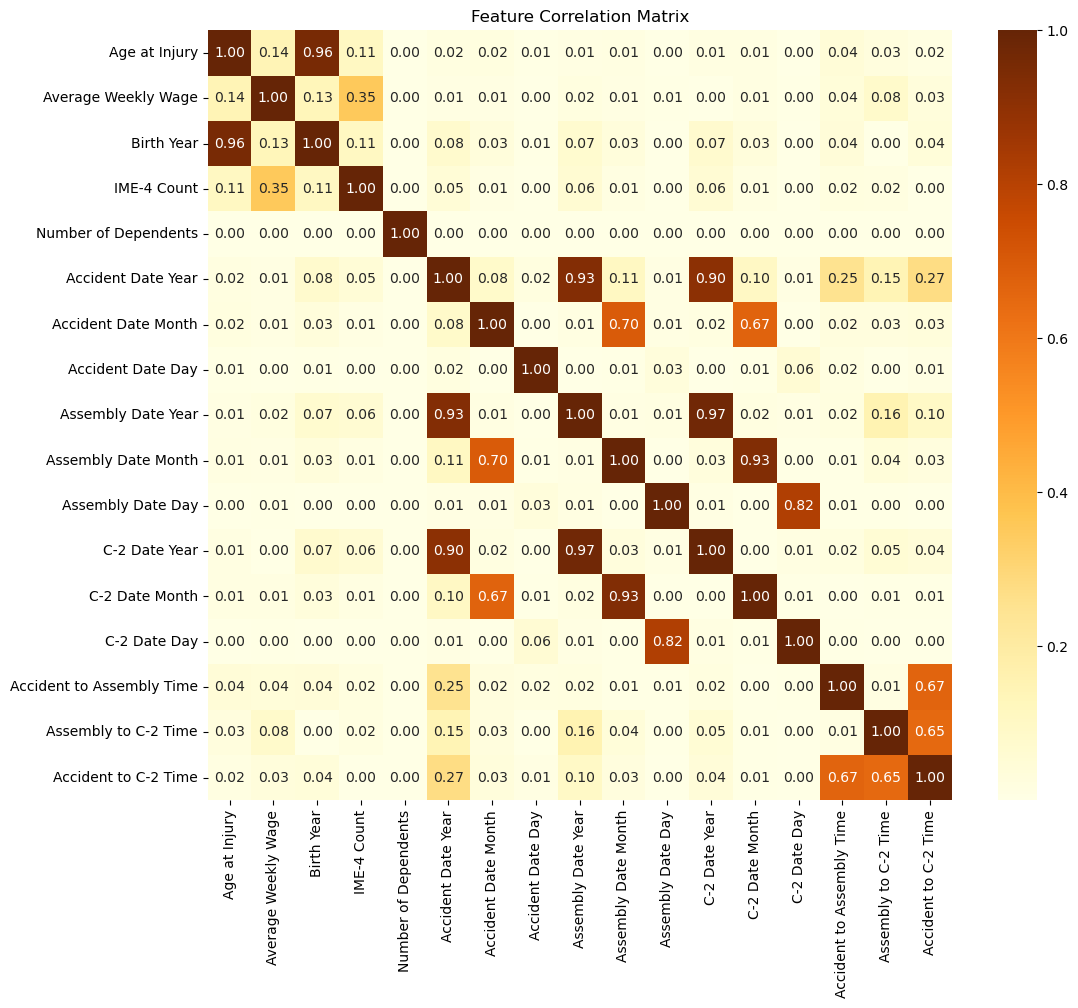

In [60]:
fs.correlation_matrix(X_train[num])

**Chi Squared Test**

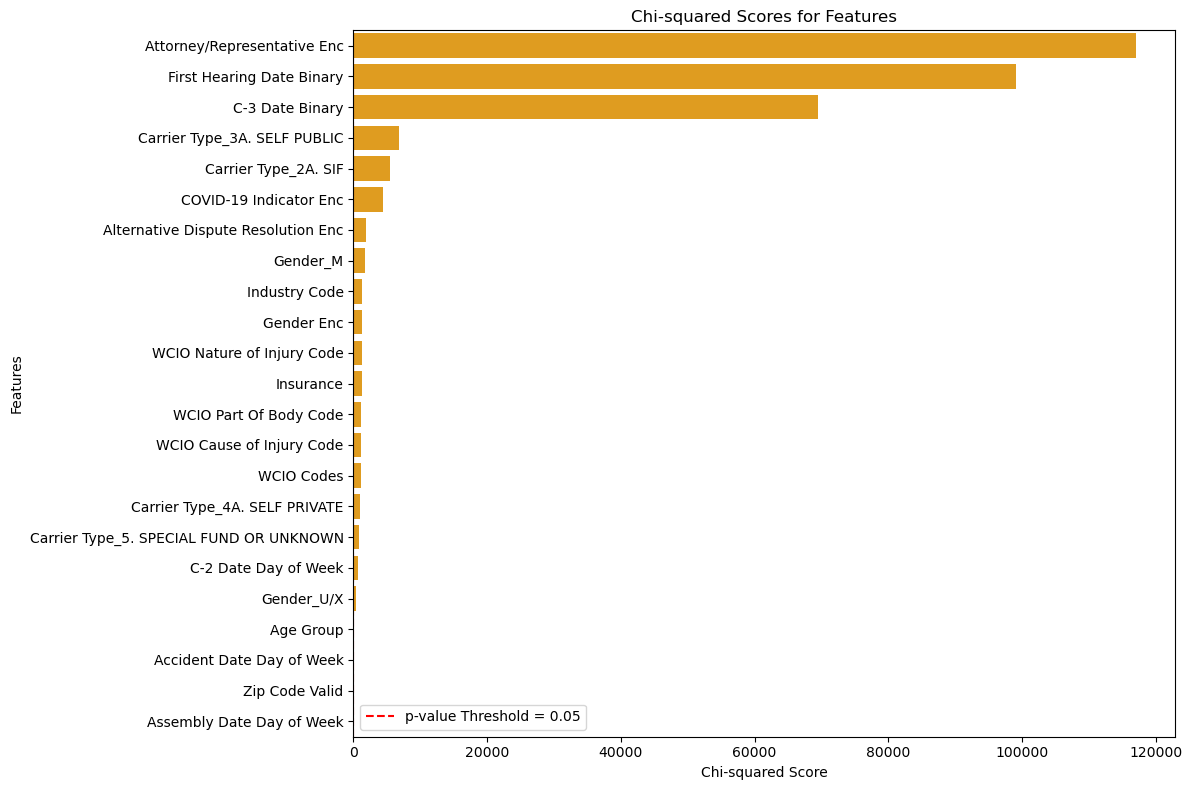


Initial Features: 23

['Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Gender Enc', 'Accident Date Day of Week', 'Assembly Date Day of Week', 'C-2 Date Day of Week', 'WCIO Codes', 'Insurance', 'Zip Code Valid', 'Age Group', 'Alternative Dispute Resolution Enc', 'Attorney/Representative Enc', 'Carrier Type_2A. SIF', 'Carrier Type_3A. SELF PUBLIC', 'Carrier Type_4A. SELF PRIVATE', 'Carrier Type_5. SPECIAL FUND OR UNKNOWN', 'COVID-19 Indicator Enc', 'Gender_M', 'Gender_U/X', 'C-3 Date Binary', 'First Hearing Date Binary']

Decision for Categorical Features (p-value < threshold): 20

['Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Gender Enc', 'C-2 Date Day of Week', 'WCIO Codes', 'Insurance', 'Age Group', 'Alternative Dispute Resolution Enc', 'Attorney/Representative Enc', 'Carrier Type_2A. SIF', 'Carrier Type_3A. SELF PUBLIC', 'Carrier Type_4A. SELF PRIVATE', 'Carrier Type_5. S

In [61]:
fs.chi_squared(X_train[categ_label_bin], y_train)

**Mutual Information Test**

In [62]:
fs.mutual_info(X_train_RS[categ], y_train, threshold = 0.05)

ValueError: Found input variables with inconsistent numbers of samples: [459220, 454700]

## 3.2 Wrapper Methods

<a href="#top">Top &#129033;</a>

Unlike filter methods, which assess features independently, wrapper methods evaluate the effectiveness of feature subsets by measuring the model’s performance, making them more computationally expensive but often more accurate in selecting relevant features.

In [63]:
imputer = SimpleImputer(strategy='mean')
X_train[['Average Weekly Wage', 'Average Weekly Wage Sqrt']] = imputer.fit_transform(X_train[['Average Weekly Wage', 'Average Weekly Wage Sqrt']])
X_val[['Average Weekly Wage', 'Average Weekly Wage Sqrt']] = imputer.transform(X_val[['Average Weekly Wage', 'Average Weekly Wage Sqrt']])

**Recursive Feature Elimination (RFE) - Logistic Regression**

In [ ]:
n_features = np.arange(2, len(X_train.columns) + 1)
model = LogisticRegression()
fs.rfe(X_train, y_train, X_val, y_val, 
    n_features = n_features, 
    model = model)

In [ ]:
import play_song as p
p.play_('audio.mp3')

**Recursive Feature Elimination (RFE) - Random Forest Classifier**

In [ ]:
# Perform Recursive Feature Elimination (RFE) to select the top features based on their importance for a logistic regression model
n_features = np.arange(5, len(X_train[num].columns) + 1)
model = RandomForestClassifier()
fs.rfe(X_train[num], y_train, n_features = n_features, model = model)

# 

## 3.3 Embedded Methods

<a href="#top">Top &#129033;</a>

These methods use algorithms that inherently select features as part of the model’s learning process. Embedded methods are computationally efficient and tend to be more accurate than filter methods, as they consider feature interactions and model performance simultaneously.


**Least Absolute Shrinkage and Selection Operator (LASSO)**

In [ ]:
fs.lasso(X_train_RS[num], y_train, alpha = 0.01)

In [ ]:
fs.lasso(X_train_RS[categ], y_train, alpha = 0.01)

**Extra Trees Classifier**

In [ ]:
fs.plot_feature_importance(X_train_RS[num], X_train_RS[categ], y_train, 
                        n_estimators = 250)

[Go to Modeling &#129034;](#modeling)

## 3.4 Final Features

<a href="#top">Top &#129033;</a>

**Final Decision**

<br>

`Numeric Variables`
<br><br>


| Variable                   | Variance | Correlation | RFE LR | RFE RF | Lasso | ExtraTrees | `Decision` |
| -------------------------- | -------- | ----------- | ------ | ------ | ----- | ---------- | ---------- |
| Accident Date Day          |    K     |             |        |        |   D   |            |            |
| Accident Date Month        |    K     |             |        |        |   D   |            |            |
| Accident Date Year         |    K     |    HC_4     |        |        |   D   |            |            |
| Accident to Assembly Time  |    K     |             |        |        |   K   |            |            |
| Accident to C-2 Time       |    K     |             |        |        |   K   |            |            |
| Age at Injury              |    K     |    HC_3     |        |        |   K   |            |            |
| Assembly Date Day          |    K     |             |        |        |   D   |            |            |
| Assembly Date Month        |    K     |             |        |        |   D   |            |            |
| Assembly Date Year         |    K     |    HC_4     |        |        |   K   |            |            |
| Assembly to C-2 Time       |    K     |             |        |        |   K   |            |            |
| Average Weekly Wage        |    K     |    HC_2     |        |        |   K   |            |            |
| Average Weekly Wage Sqrt   |    K     |    HC_2     |        |        |   K   |            |            |
| Birth Year                 |    K     |    HC_3     |        |        |   K   |            |            |
| C-2 Date Day               |    K     |             |        |        |   K   |            |            |
| C-2 Date Month             |    K     |             |        |        |   K   |            |            |
| C-2 Date Year              |    K     |    HC_4     |        |        |   D   |            |            |
| IME-4 Count                |    K     |    HC_1     |        |        |   K   |            |            |
| IME-4 Count Double Log     |    K     |    HC_1     |        |        |   D   |            |            |
| IME-4 Count Log            |    K     |    HC_1     |        |        |   K   |            |            |
| Number of Dependents       |    K     |             |        |        |   D   |            |            |
| Wage to Age Ratio          |    K     |             |        |        |   K   |            |            |

<br>

`Categorical Variables`
<br><br>


| Variable                                | Chi-Squared | MI | RFE LR | RFE RF | Lasso | Extra trees | `Decision` |
| --------------------------------------- | ----------- | -- | ------ | ------ | ----- | ----------- | ---------- |
| Accident Date Day of Week               |      D      | D  |        |        |   K   |             |            |
| Assembly Date Day of Week               |      D      | D  |        |        |   K   |             |            |
| Age Group                               |      K      | K  |        |        |   K   |             |            |
| Alternative Dispute Resolution Bin      |      K      | D  |        |        |   K   |             |            |
| Attorney/Representative Bin             |      K      | K  |        |        |   K   |             |            |
| Carrier Name Enc                        |      K      | K  |        |        |   K   |             |            |
| Carrier Type Enc                        |      NA     | D  |        |        |   K   |             |            |
| Carrier Type_2A. SIF                    |      K      | D  |        |        |   D   |             |            |
| Carrier Type_3A. SELF PUBLIC            |      K      | D  |        |        |   D   |             |            |
| Carrier Type_4A. SELF PRIVATE           |      K      | D  |        |        |   D   |             |            |
| Carrier Type_5. SPECIAL FUND OR UNKNOWN |      K      | D  |        |        |   D   |             |            |
| C-2 Date Day of Week                    |      K      | D  |        |        |   K   |             |            |
| C-3 Date Binary                         |      K      | K  |        |        |   K   |             |            |
| COVID-19 Indicator Enc                  |      K      | D  |        |        |   K   |             |            |
| County of Injury Enc                    |      NA     | D  |        |        |   K   |             |            |
| District Name Enc                       |      NA     | D  |        |        |   K   |             |            |
| First Hearing Date Binary               |      K      | K  |        |        |   K   |             |            |
| Gender Enc                              |      K      | D  |        |        |   K   |             |            |
| Gender_M                                |      K      | D  |        |        |   D   |             |            |
| Gender_U/X                              |      K      | D  |        |        |   D   |             |            |
| Industry Code                           |      K      | K  |        |        |   K   |             |            |
| Industry Sector Enc                     |      NA     | D  |        |        |   K   |             |            |
| Insurance                               |      K      | D  |        |        |   D   |             |            |
| Medical Fee Region Enc                  |      NA     | D  |        |        |   K   |             |            |
| WCIO Cause of Injury Code               |      K      | K  |        |        |   K   |             |            |
| WCIO Codes                              |      K      | K  |        |        |   K   |             |            |
| WCIO Nature of Injury Code              |      K      | K  |        |        |   K   |             |            |
| WCIO Part Of Body Code                  |      K      | K  |        |        |   K   |             |            |
| Zip Code Valid                          |      D      | D  |        |        |   D   |             |            |

<br><br><br>

| Symbol | Meaning |
| ------ | ------- |
| K      | Keep    |
| D      | Discard |
| HC_*N*   | High Correlation Identifier |
| NA     | Not Applicable |


# 4. Modeling

<a class="anchor" id="modeling"></a>

[Go to Feature Selection &#129034;](#feature-selection)

<a href="#top">Top &#129033;</a>

Start by importing the correct datasets.


In [3]:
# X_train = pd.read_csv('./data/X_train_treated.csv', index_col = 'Claim Identifier')
# X_val = pd.read_csv('./data/X_val_treated.csv', index_col = 'Claim Identifier')
# y_train = pd.read_csv('./data/y_train_treated.csv', index_col = 'Claim Identifier')
# y_val = pd.read_csv('./data/y_val_treated.csv', index_col = 'Claim Identifier')
# test = pd.read_csv('./data/test_treated.csv', index_col = 'Claim Identifier')

And select the columns to use for predictions purposes

In [50]:
columns = []


X_train_filtered = X_train_RS[columns]
X_val_filtered = X_val_RS[columns]
test_filtered = test_RS[columns]

**Model Training**

In [ ]:
# Define the models to run
model_names = ['LGBM', 'KNN', 'DT', 'RF','XGB']

results = mod.modeling(model_names, X_train_filtered, y_train, X_val_filtered, y_val)

In [ ]:
import play_song as s
s.play_('audio.mp3')

** ** 

Scaling before using ball_trees

In [ ]:
#extra_t = pd.DataFrame(results).T
extra_t

In [ ]:
#lasso_num_MIC_categ = pd.DataFrame(results).T
lasso_num_MIC_categ

In [ ]:
#lasso_feat = pd.DataFrame(results).T
lasso_feat

In [ ]:
#no_out_noWageratio_noSQRT = pd.DataFrame(results).T
no_out_noWageratio_noSQRT

** **

Scaling after using ball_trees

In [ ]:
#out_treat_drop_ADR_with_IME_logs_RS = pd.DataFrame(results).T
out_treat_drop_ADR_with_IME_logs_RS 

In [ ]:
#outlier_treatment_drop_ADR_with_IME_logs = pd.DataFrame(results).T
outlier_treatment_drop_ADR_with_IME_logs

In [ ]:
#outlier_treatment_drop_ADR = pd.DataFrame(results).T
outlier_treatment_drop_ADR

In [ ]:
#outlier_treatment = pd.DataFrame(results).T
outlier_treatment

In [ ]:
#no_outlier_treatment = pd.DataFrame(results).T
no_outlier_treatment

## 4.1 Hyperparameter Tuning

<a href="#top">Top &#129033;</a>

In [52]:
param_grid = {
    "n_estimators": [375, 400, 425],
    "max_depth": [23, 25, 27],   
#   "min_samples_split": [4, 5],   
#    "min_samples_leaf": [6, 8],     
#   "max_features": ['auto', 'sqrt', 'log2'],  
    "bootstrap": [True, False],       
    "criterion": ['gini', 'entropy']  
}

model = RandomForestClassifier(random_state = 1)

In [ ]:
t.hyperparameter_search(model, param_grid, 'random', X_train_RS, 
                      y_train, scoring='f1_macro', 
                      cv=3, n_iter=5, random_state=42)

In [ ]:
import play_song as s
s.play_('audio.mp3')

## 4.2 Final Predictions

<a href="#top">Top &#129033;</a>

In [16]:
test_filtered = test

In [17]:
test_filtered['Claim Injury Type'] = model.predict(test_filtered)

Map Predictions to Original Values

In [18]:
label_mapping = {
    0: "1. CANCELLED",
    1: "2. NON-COMP",
    2: "3. MED ONLY",
    3: "4. TEMPORARY",
    4: "5. PPD SCH LOSS",
    5: "6. PPD NSL",
    6: "7. PTD",
    7: "8. DEATH"
}


test_filtered['Claim Injury Type'] = test_filtered['Claim Injury Type'].replace(label_mapping)

In [ ]:
# Count unique values in column 'Claim Injury Type'
test_filtered['Claim Injury Type'].value_counts() 

In [20]:
# Extract the target variable 'Claim Injury Type' from the test dataset for prediction
predictions = test_filtered['Claim Injury Type']

In [21]:
# Assign a descriptive name for easy reference
name = 'all_feat_all_correct'

# Save the predictions to a CSV file.
predictions.to_csv(f'./pred/{name}.csv')